<a href="https://colab.research.google.com/github/nadya1462/sirius_2022/blob/main/Seminar_3_Coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar 3. Patterns encoding: Brian2 realizations

In [ ]:
!pip install brian2
!pip install --upgrade numpy
!pip install --upgrade matplotlib

In [1]:
import numpy as np
import brian2 as b2
from matplotlib import pyplot as plt
%matplotlib inline

### Make the patterns

In [2]:
max_intensity = 255
min_intensity = 0
ni = 4

right_intensity = np.arange(ni) * max_intensity / (ni - 1)
print(right_intensity)

left_intensity = np.arange(ni - 1, -1, -1) * max_intensity / (ni - 1)
print(left_intensity)

[  0.  85. 170. 255.]
[255. 170.  85.   0.]


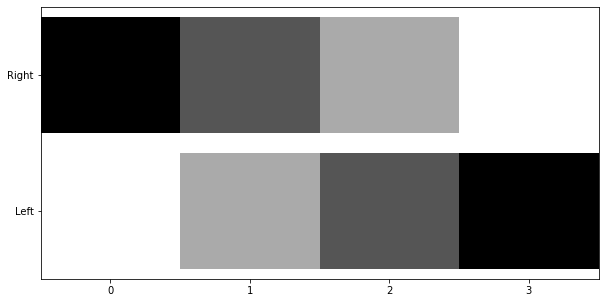

In [3]:
def draw_intensity(intensity_samples, minI, maxI):
  x = np.arange(-0.5, ni, 1)
  y = np.arange(-0.5, 2, 1)
  fig, ax = plt.subplots(figsize=(10,5))
  ax.set_xticks(range(ni))
  ax.set_yticks([0, 1])
  ax.set_yticklabels(["Left", "Right"])
  ax.pcolormesh(x, y, intensity_samples, cmap='gray', vmin=minI, vmax=maxI)
  # for k in x:
  #   plt.axvline(k, ls='-', c='w', lw=4) # white line between bars
  for k in y:
    plt.axhline(k, ls='-', c='white', lw=20) # white line between samples

intensities = np.array([left_intensity, right_intensity])
draw_intensity(intensities, min_intensity, max_intensity)

### Encode the patterns

**Count Rate coding**

In [4]:
input_rates = right_intensity * b2.Hz # or left_intensity

print(input_rates)

[  0.  85. 170. 255.] Hz


In [10]:
input_group = b2.PoissonGroup(ni, rates = input_rates)

Poisson distribution: 
$$ P\{x = k\} = \dfrac{λ^ke^{-λ}}{k!} $$

k -- the number of occurrences

λ -- the expected rate of occurrences  


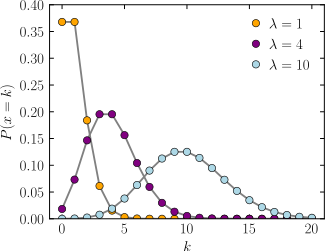

In [11]:
model_n = '''
dv/dt = (v_rest-v)/tau : volt
v_rest : volt
v_reset : volt
vt : volt
tau : second
'''
group_n = b2.NeuronGroup(4, model_n, threshold = 'v > vt', reset = 'v = v_reset', method = 'exact')
group_n.v = -65 * b2.mV
group_n.v_rest = -65 * b2.mV
group_n.v_reset = -65 * b2.mV
group_n.vt = -52 * b2.mV
group_n.tau = 1 * b2.ms

synapses_e = b2.Synapses(input_group, group_n, on_pre = 'v += 0.01 * volt')
synapses_e.connect(condition = 'i == j')

i_spike_mon = b2.SpikeMonitor(input_group)
n_spike_mon = b2.SpikeMonitor(group_n)
n_state_mon = b2.StateMonitor(group_n, ['v', 'vt'], record=True)

b2.run(100 * b2.ms)

In [12]:
for n in range(ni):
  print(f"t of spikes from {n+1} input neuron", i_spike_mon.spike_trains()[n])

t of spikes from 1 input neuron [] s
t of spikes from 2 input neuron [ 5.6  8.7 25.8 28.4 30.9 45.4 52.5 62.3 69.8 84.4 85.4] ms
t of spikes from 3 input neuron [ 6.8 21.7 26.9 41.4 47.9 84.  87.3 88.  90.2 94.1 95.  97.7] ms
t of spikes from 4 input neuron [ 2.1  8.1 16.7 25.9 32.6 33.4 34.4 35.9 40.2 41.4 46.2 48.5 50.4 53.6
 55.3 55.8 60.2 70.3 75.4 78.8 81.7 82.  83.6 84.4 85.8 88.7 90.5 92.4
 92.5 94.  97.5] ms


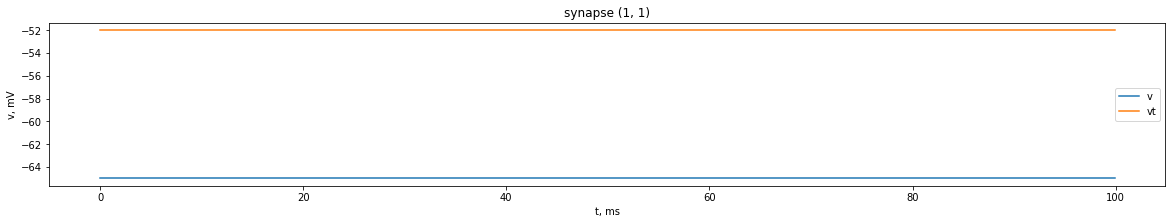

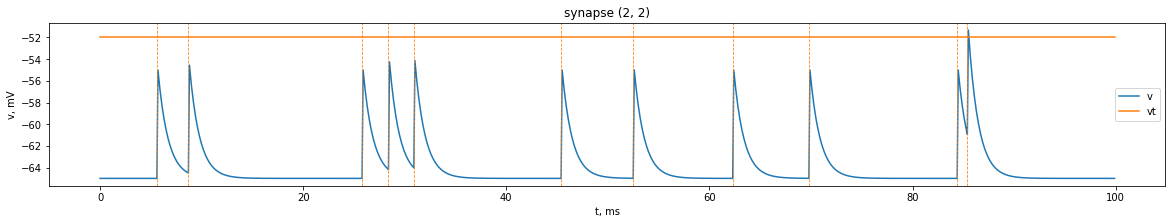

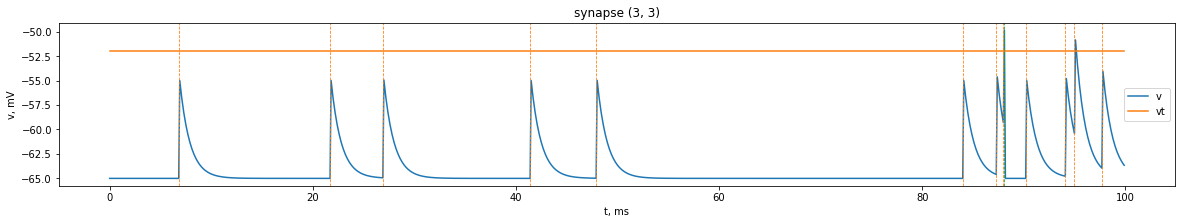

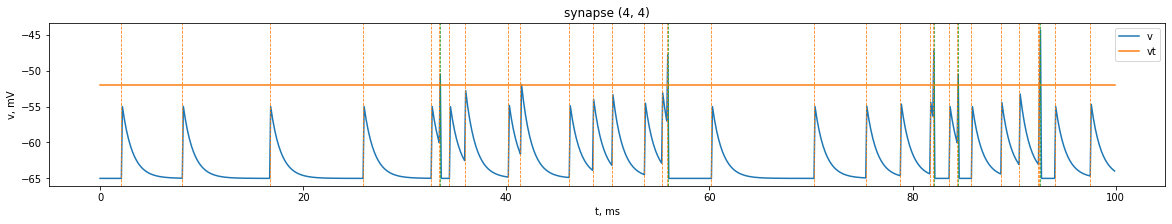

In [13]:
def show_plots(i_spike_mon, n_spike_mon, n_state_mon):
    for s in range(ni):
        plt.figure(figsize=(20,3))
        plt.plot(n_state_mon.t/b2.ms, n_state_mon.v[s]/b2.mV, label = 'v')
        plt.plot(n_state_mon.t/b2.ms, n_state_mon.vt[s]/b2.mV , label = 'vt')
        for t in i_spike_mon.spike_trains()[s]:
            plt.axvline(t/b2.ms, ls = '--', c = 'C1', lw = 0.8) # orange == pre
        for t in n_spike_mon.spike_trains()[s]:
            plt.axvline(t/b2.ms, ls = '--', c = 'C2', lw = 0.8) # green == post
        plt.legend()
        plt.xlabel("t, ms")
        plt.ylabel("v, mV")
        plt.title(f"synapse ({s+1}, {s+1})")
        
show_plots(i_spike_mon, n_spike_mon, n_state_mon)

**TTFS coding**

In [14]:
right_intensity_norm = (right_intensity - min_intensity) / (max_intensity - min_intensity) 
left_intensity_norm = (left_intensity - min_intensity) / (max_intensity - min_intensity) 

print(right_intensity_norm)
print(left_intensity_norm)

[0.         0.33333333 0.66666667 1.        ]
[1.         0.66666667 0.33333333 0.        ]


In [15]:
min_spike_time = 0
max_spike_time = 3

In [16]:
input_times = - (max_spike_time - min_spike_time) * right_intensity_norm + max_spike_time  # or left_intensity_norm

print(input_times)

[3. 2. 1. 0.]


In [21]:
b2.start_scope()

input_group = b2.SpikeGeneratorGroup(ni, indices = list(range(ni)), times = input_times * b2.ms, period = 8 * b2.ms)

In [22]:
model_n = '''
dv/dt = (v_rest-v)/tau : volt
v_rest : volt
v_reset : volt
vt : volt
tau : second
'''
group_n = b2.NeuronGroup(4, model_n, threshold = 'v > vt', reset = 'v = v_reset', method = 'exact')
group_n.v = -65 * b2.mV
group_n.v_rest = -65 * b2.mV
group_n.v_reset = -65 * b2.mV
group_n.vt = -52 * b2.mV
group_n.tau = 1 * b2.ms

synapses_e = b2.Synapses(input_group, group_n, on_pre = 'v += 0.01 * volt')
synapses_e.connect(condition = 'i == j')

i_spike_mon = b2.SpikeMonitor(input_group)
n_spike_mon = b2.SpikeMonitor(group_n)
n_state_mon = b2.StateMonitor(group_n, ['v', 'vt'], record=True)

b2.run(20 * b2.ms)

WARNING    'i' is an internal variable of group 'synapses', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [23]:
for i in range(ni):
  print(f"t of spikes from {i+1} input neuron", i_spike_mon.spike_trains()[i])

t of spikes from 1 input neuron [ 3. 11. 19.] ms
t of spikes from 2 input neuron [ 2. 10. 18.] ms
t of spikes from 3 input neuron [ 1.  9. 17.] ms
t of spikes from 4 input neuron [ 0.  8. 16.] ms


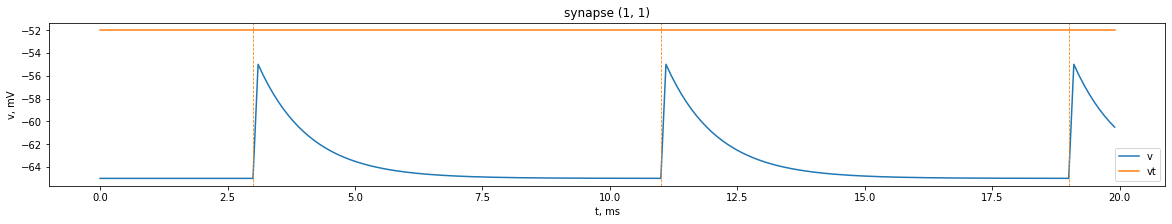

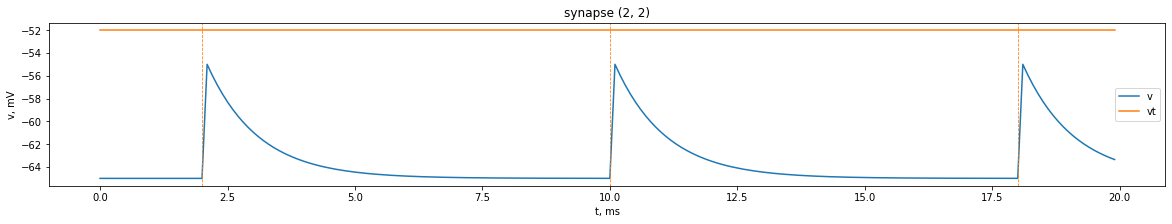

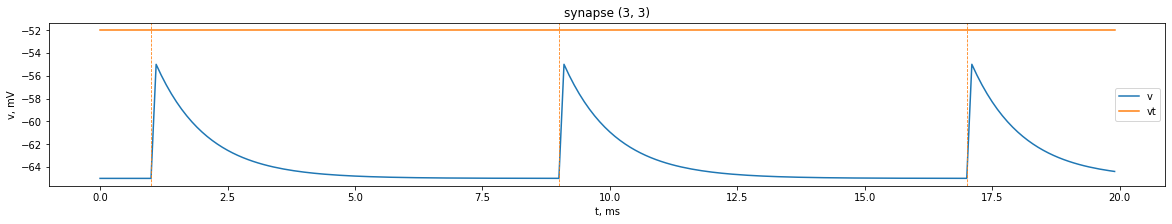

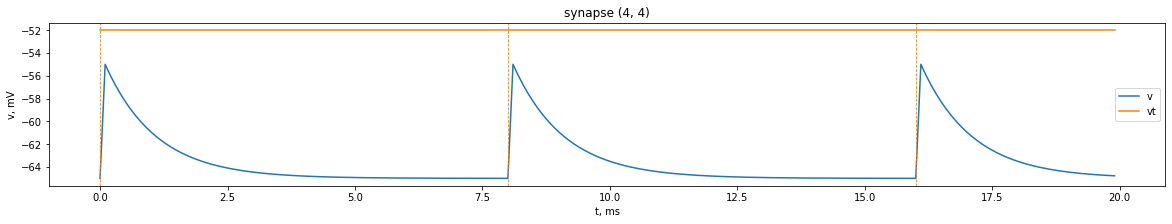

In [24]:
def show_plots(i_spike_mon, n_spike_mon, n_state_mon):
    for s in range(ni):
        plt.figure(figsize=(20,3))
        plt.plot(n_state_mon.t/b2.ms, n_state_mon.v[s]/b2.mV, label = 'v')
        plt.plot(n_state_mon.t/b2.ms, n_state_mon.vt[s]/b2.mV , label = 'vt')
        for t in i_spike_mon.spike_trains()[s]:
            plt.axvline(t/b2.ms, ls = '--', c = 'C1', lw = 0.8) # orange == pre
        for t in n_spike_mon.spike_trains()[s]:
            plt.axvline(t/b2.ms, ls = '--', c = 'C2', lw = 0.8) # green == post
        plt.legend()
        plt.xlabel("t, ms")
        plt.ylabel("v, mV")
        plt.title(f"synapse ({s+1}, {s+1})")
        
show_plots(i_spike_mon, n_spike_mon, n_state_mon)

In [27]:
b2.start_scope()

input_group = b2.SpikeGeneratorGroup(ni, indices = list(range(ni)), times = input_times * b2.ms, period = 8 * b2.ms) 

In [28]:
model_n = '''
dv/dt = (v_rest-v)/tau : volt
v_rest : volt
v_reset : volt
vt : volt
tau : second
'''
group_n = b2.NeuronGroup(1, model_n, threshold = 'v > vt', reset = 'v = v_reset', method = 'exact') # we have changed the number of main neurons !!!
group_n.v = -65 * b2.mV
group_n.v_rest = -65 * b2.mV
group_n.v_reset = -65 * b2.mV
group_n.vt = -52 * b2.mV
group_n.tau = 1 * b2.ms 

synapses_e = b2.Synapses(input_group, group_n, on_pre = 'v += 0.01 * volt')
synapses_e.connect()

i_spike_mon = b2.SpikeMonitor(input_group)
n_spike_mon = b2.SpikeMonitor(group_n)
n_state_mon = b2.StateMonitor(group_n, ['v', 'vt'], record=True)

b2.run(20 * b2.ms)

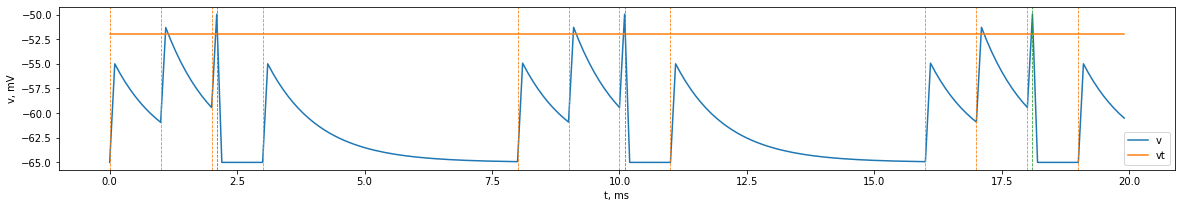

In [29]:
def show_plots(i_spike_mon, n_spike_mon, n_state_mon):
    plt.figure(figsize=(20,3))
    plt.plot(n_state_mon.t/b2.ms, n_state_mon.v[0]/b2.mV, label = 'v')
    plt.plot(n_state_mon.t/b2.ms, n_state_mon.vt[0]/b2.mV , label = 'vt')
    for s in range(ni):
        for t in i_spike_mon.spike_trains()[s]:
            plt.axvline(t/b2.ms, ls = '--', c = 'C1', lw = 0.8) # orange == pre
    for t in n_spike_mon.spike_trains()[0]:
        plt.axvline(t/b2.ms, ls = '--', c = 'C2', lw = 0.8) # green == post
    plt.legend()
    plt.xlabel("t, ms")
    plt.ylabel("v, mV")
        
show_plots(i_spike_mon, n_spike_mon, n_state_mon)

**Phase coding**

In [30]:
int_right_intensity = list(map(round, right_intensity)) # now we can transfer numbers to binary form
print("Integer right intensities:")
print(int_right_intensity)

bin_intensity = []
for num in int_right_intensity:
    bin_num = int(format(num, 'b'))
    bin_intensity.append(f'{bin_num:08}')
print("Binary intensities:")
print(bin_intensity, '\n')

Integer right intensities:
[0, 85, 170, 255]
Binary intensities:
['00000000', '01010101', '10101010', '11111111'] 



In [31]:
def times_func(str_bin_num):
    var = np.array(list(str_bin_num))
    sp_times = np.where(var == '1')[0]
    sp_amount = len(sp_times)
    return sp_times, sp_amount

print("Corresponding spiking times:")
times = []
indices = []
for k in range(len(bin_intensity)):
    sp_times, sp_amount = times_func(bin_intensity[k])
    print(sp_times)
    times.append(sp_times)
    indices.append([k] * sp_amount)

print("Corresponding input neuron indicies:")
print(indices)

Corresponding spiking times:
[]
[1 3 5 7]
[0 2 4 6]
[0 1 2 3 4 5 6 7]
Corresponding input neuron indicies:
[[], [1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3, 3, 3, 3, 3]]


In [32]:
times_one_arr = []
for arr in times:
    for elem in arr:
        times_one_arr.append(elem)
print("Spiking times:")
print(times_one_arr)

indices_one_arr = []
for arr in indices:
    for elem in arr:
        indices_one_arr.append(elem)
print("Input neuron indicies:")
print(indices_one_arr)

Spiking times:
[1, 3, 5, 7, 0, 2, 4, 6, 0, 1, 2, 3, 4, 5, 6, 7]
Input neuron indicies:
[1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]


In [33]:
b2.start_scope()

input_group = b2.SpikeGeneratorGroup(ni, indices = indices_one_arr, times = times_one_arr * b2.ms, period = 8 * b2.ms)

In [34]:
model_n = '''
dv/dt = (v_rest-v)/tau : volt
v_rest : volt
v_reset : volt
vt : volt
tau : second
'''
group_n = b2.NeuronGroup(4, model_n, threshold = 'v > vt', reset = 'v = v_reset', method = 'exact')
group_n.v = -65 * b2.mV
group_n.v_rest = -65 * b2.mV
group_n.v_reset = -65 * b2.mV
group_n.vt = -52 * b2.mV
group_n.tau = 1 * b2.ms

synapses_e = b2.Synapses(input_group, group_n, on_pre = 'v += 0.01 * volt')
synapses_e.connect(condition = 'i == j')

i_spike_mon = b2.SpikeMonitor(input_group)
n_spike_mon = b2.SpikeMonitor(group_n)
n_state_mon = b2.StateMonitor(group_n, ['v', 'vt'], record=True)

b2.run(20 * b2.ms)

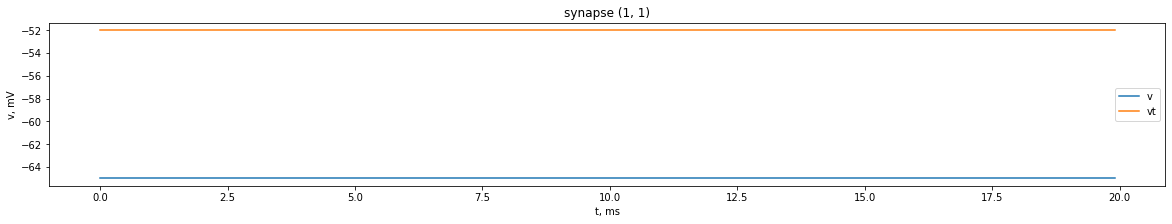

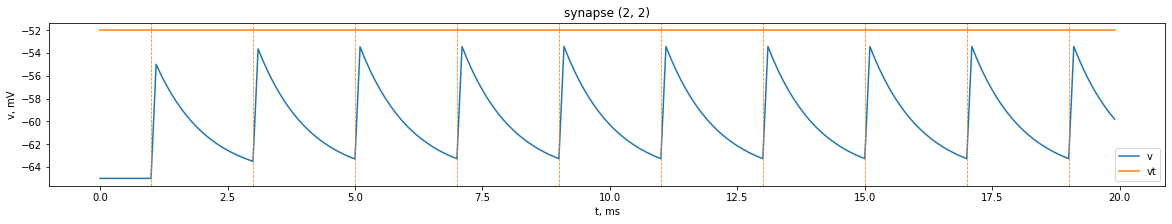

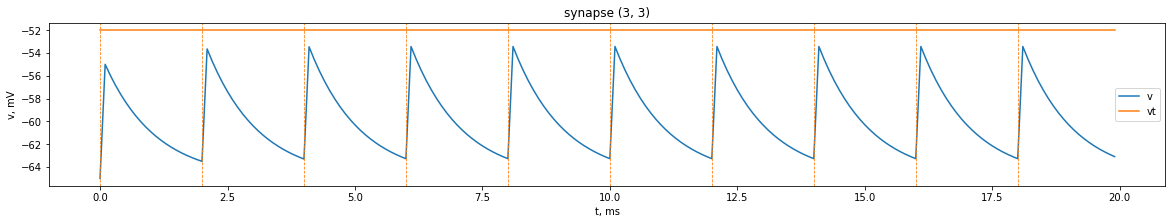

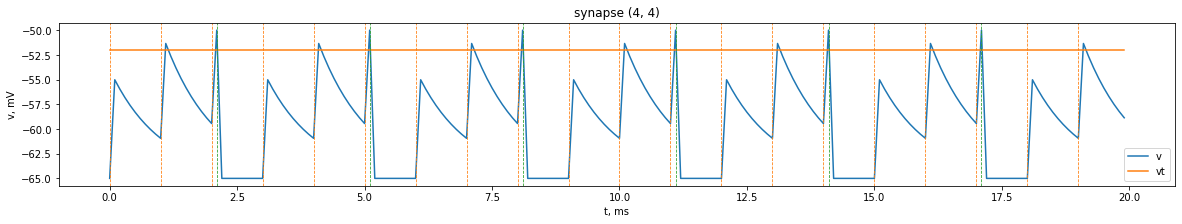

In [35]:
def show_plots(i_spike_mon, n_spike_mon, n_state_mon):
    for s in range(ni):
        plt.figure(figsize=(20,3))
        plt.plot(n_state_mon.t/b2.ms, n_state_mon.v[s]/b2.mV, label = 'v')
        plt.plot(n_state_mon.t/b2.ms, n_state_mon.vt[s]/b2.mV , label = 'vt')
        for t in i_spike_mon.spike_trains()[s]:
            plt.axvline(t/b2.ms, ls = '--', c = 'C1', lw = 0.8) # orange == pre
        for t in n_spike_mon.spike_trains()[s]:
            plt.axvline(t/b2.ms, ls = '--', c = 'C2', lw = 0.8) # green == post
        plt.legend()
        plt.xlabel("t, ms")
        plt.ylabel("v, mV")
        plt.title(f"synapse ({s+1}, {s+1})")
        
show_plots(i_spike_mon, n_spike_mon, n_state_mon)

but spikes must have different weights!

**Burst coding**

In [27]:
b2.start_scope()